In [1]:
import torch
import torch.fft
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import h5py

import fastmri 
from fastmri.fftc import fft2c_new, ifft2c_new
from fastmri.math import complex_abs

from torch.distributions import multivariate_normal

#os.chdir('/content/drive/MyDrive/MRI/MRI_Project')
#import deepbrainnew
#from deepbrainnew import Extractor
import nibabel as nib
import skimage
import pandas as pd
from h5_dataloader import MRIDataset_h5
from loss import mse,nmse,psnr,ssim

import math
import time 

import skimage.transform as skTrans
#im = nib.load(file_path).get_fdata()
#result1 = skTrans.resize(im, (160,160,130), order=1, preserve_range=True)

imgsz = 256
w = 48

In [2]:
######### Reconstruction Function #########

def zerofill_samp(img1_k,ind):
  img_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img_r = img_r.reshape(imgsz,imgsz)
  pixnum = len(ind)
  img1_k_ = img1_k[w:imgsz-w,w:imgsz-w,:]
  picked_r = img1_k_[:,:,0].reshape(-1,1)
  picked_i = img1_k_[:,:,1].reshape(-1,1)

  for i in range((imgsz-2*w)**2):
    if i not in ind:
      picked_r[i,0] = 0 
      picked_i[i,0] = 0 

  picked_r = picked_r.reshape(imgsz-2*w,imgsz-2*w)
  picked_i = picked_i.reshape(imgsz-2*w,imgsz-2*w)

  picked_k = torch.stack([picked_r,picked_i],dim = 2) 

  whole_k = torch.zeros(imgsz,imgsz,2)
  whole_k[w:imgsz-w,w:imgsz-w,:] = picked_k
  rcon = fastmri.complex_abs(ifft2c_new(whole_k))
  
  nmse_ =  nmse(img_r.numpy(),rcon.numpy())
  ssim_ =  ssim(img_r.numpy(),rcon.numpy())
  psnr_ = psnr(img_r.numpy(),rcon.numpy())
  

  return rcon,nmse_,ssim_,psnr_


def zerofill_samp_imgsz(img1_k,ind):
  pixnum = len(ind)

  picked_r = img1_k[:,:,0].view(-1,1)
  picked_i = img1_k[:,:,1].view(-1,1)

  for i in range(imgsz*imgsz):
    if i not in ind:
      picked_r[i,0] = 0 
      picked_i[i,0] = 0 

  picked_r = picked_r.reshape(imgsz,imgsz)
  picked_i = picked_i.reshape(imgsz,imgsz)

  rcon = fastmri.complex_abs(ifft2c_new(torch.stack([picked_r,picked_i],dim=2)))
  
  nmse_ =  nmse(img1_r.numpy(),rcon.numpy())
  ssim_ =  ssim(img1_r.numpy(),rcon.numpy())
  psnr_ = psnr(img1_r.numpy(),rcon.numpy())
  return rcon,nmse_,ssim_,psnr_



def bayesian_stat_r(img_k1,ind,sig,ind_previous = None):
  #img_k1 size: cropped sized (imgsz-2*w, imgsz-2*w)

  pixnum = len(ind)

  realcovmat = realcov[ind,:][:,ind] + sig*torch.eye(pixnum)
  imagcovmat = imagcov[ind,:][:,ind] + sig*torch.eye(pixnum)

  realcovvec = realcov[:,ind]
  imagcovvec = imagcov[:,ind]  

  for i in range(len(ind)):
    realcovmat[i,i] = realvar[ind[i]] + sig
    imagcovmat[i,i] = imagvar[ind[i]] + sig
    realcovvec[ind[i],i] = realvar[ind[i]]
    imagcovvec[ind[i],i] = imagvar[ind[i]]

  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img_k1[:,:,0]-realmean).view(-1,1)[ind])) + realmean.view(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img_k1[:,:,1]-imagmean).view(-1,1)[ind])) + imagmean.view(-1,1)


  rvar = realvar - torch.sum(torch.matmul(realcov[:,ind],torch.inverse(realcovmat))*realcov[:,ind],1) + sig 
  ivar = imagvar - torch.sum(torch.matmul(imagcov[:,ind],torch.inverse(imagcovmat))*imagcov[:,ind],1) + sig

  if ind_previous != None: 
    ind = torch.cat([ind_previous,ind])

  rmean[ind] = (img_k1[:,:,0].reshape((imgsz-2*w)**2,1))[ind]
  imean[ind] = (img_k1[:,:,1].reshape((imgsz-2*w)**2,1))[ind]

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  #set all sampled (previous + current) position variance as sigma
 # rvar[ind] = sig
 # ivar[ind] = sig


  return rmean,imean,rvar,ivar


def bayesian_stat_r_nor(img_k1,ind,sig,realcov_,imagcov_,ind_previous = None):
  #img_k1 size: cropped sized (imgsz-2*w, imgsz-2*w)

  pixnum = len(ind)

  realcovmat = realcov_[ind,:][:,ind] + sig*torch.eye(pixnum)
  imagcovmat = imagcov_[ind,:][:,ind] + sig*torch.eye(pixnum)

  realcovvec = realcov_[:,ind]
  imagcovvec = imagcov_[:,ind]  

  for i in range(len(ind)):
    realcovmat[i,i] = realvar[ind[i]] + sig
    imagcovmat[i,i] = imagvar[ind[i]] + sig
    realcovvec[ind[i],i] = realvar[ind[i]]
    imagcovvec[ind[i],i] = imagvar[ind[i]]

  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img_k1[:,:,0]/magmean-realmean).view(-1,1)[ind])) + realmean.view(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img_k1[:,:,1]/magmean-imagmean).view(-1,1)[ind])) + imagmean.view(-1,1)
  
  #mag_nor = torch.sqrt(rmean**2+imean**2)
  #rmean = rmean/mag_nor 
  #imean = imean/mag_nor 
  #rmean[mag_nor == 0] = 0 
  #imean[mag_nor == 0] = 0 
#for the sampled areas 
  rmean[ind] = ((img_k1[:,:,0]/magmean).reshape((imgsz-2*w)**2,1))[ind]
  imean[ind] = ((img_k1[:,:,1]/magmean).reshape((imgsz-2*w)**2,1))[ind]

  rvar = realvar - torch.sum(torch.matmul(realcov[:,ind],torch.inverse(realcovmat))*realcov[:,ind],1) + sig 
  ivar = imagvar - torch.sum(torch.matmul(imagcov[:,ind],torch.inverse(imagcovmat))*imagcov[:,ind],1) + sig

  if ind_previous != None: 
    ind = torch.cat([ind_previous,ind])

 
  kmean = torch.stack([(rmean).reshape(imgsz-2*w,imgsz-2*w)*magmean,\
                         (imean).reshape(imgsz-2*w,imgsz-2*w)*magmean],dim=2)   
  

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  #set all sampled (previous + current) position variance as sigma
 # rvar[ind] = sig
 # ivar[ind] = sig


  return rmean,imean,kmean,rvar,ivar

  
def bayesian_mean_samp(img1_k,realmat,imagmat,ind,lamb):
  pixnum = len(ind)

  #ind = torch.randint(0,imgsz*imgsz,(pixnum,))
  img1_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img1_r = img1_r.reshape(imgsz,imgsz)
  img1_k_ = (img1_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]
  
  realcovmat = realmat[ind,:][:,ind] + lamb*torch.eye(pixnum)
  imagcovmat = imagmat[ind,:][:,ind] + lamb*torch.eye(pixnum)

  realcovvec = realmat[:,ind]
  imagcovvec = imagmat[:,ind]  
  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img1_k_[:,:,0]-realmean).view(-1,1)[ind])) + realmean.reshape(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img1_k_[:,:,1]-imagmean).view(-1,1)[ind])) + imagmean.reshape(-1,1)

  rmean[ind] = img1_k_[:,:,0].reshape(-1,1)[ind]
  imean[ind] = img1_k_[:,:,1].reshape(-1,1)[ind]

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  kmean = torch.stack([rmean.reshape(imgsz-2*w,imgsz-2*w),imean.reshape(imgsz-2*w,imgsz-2*w)],dim=2)
  kmean_whole = torch.zeros(imgsz,imgsz,2)
  kmean_whole[w:imgsz-w,w-1:imgsz-w,:] = kmean
  bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))
  
  nmse_ =  nmse(img1_r.numpy(),bayesian_mean.numpy())
  ssim_ =  ssim(img1_r.numpy(),bayesian_mean.numpy())
  psnr_ = psnr(img1_r.numpy(),bayesian_mean.numpy())
  
  return bayesian_mean,nmse_,ssim_,psnr_

def bayesian_mean_samp_new(img1_k,ind,lamb):
  pixnum = len(ind)

  #ind = torch.randint(0,imgsz*imgsz,(pixnum,))
  img1_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img1_r = img1_r.reshape(imgsz,imgsz)
  img1_k_ = (img1_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]
  
  realcovmat = realcov[ind,:][:,ind] 
  imagcovmat = imagcov[ind,:][:,ind] 

  for i in range(len(ind)): 
    realcovmat[i,i] = realvar[ind[i]] + lamb*torch.abs(realmean.view(-1)[ind[i]])
    imagcovmat[i,i] = imagvar[ind[i]] +  lamb*torch.abs(imagmean.view(-1)[ind[i]])

  realcovvec = realcov[:,ind]
  imagcovvec = imagcov[:,ind]  
  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img1_k_[:,:,0]-realmean).view(-1,1)[ind])) + realmean.reshape(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img1_k_[:,:,1]-imagmean).view(-1,1)[ind])) + imagmean.reshape(-1,1)

  rmean[ind] = img1_k_[:,:,0].reshape(-1,1)[ind]
  imean[ind] = img1_k_[:,:,1].reshape(-1,1)[ind]

  rmean = rmean.reshape(imgsz-2*w,imgsz-2*w)
  imean = imean.reshape(imgsz-2*w,imgsz-2*w)

  kmean = torch.stack([rmean.reshape(imgsz-2*w,imgsz-2*w),imean.reshape(imgsz-2*w,imgsz-2*w)],dim=2)
  kmean_whole = torch.zeros(imgsz,imgsz,2)
  kmean_whole[w:imgsz-w,w:imgsz-w,:] = kmean
  bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))
  
  nmse_ =  nmse(img1_r.numpy(),bayesian_mean.numpy())
  ssim_ =  ssim(img1_r.numpy(),bayesian_mean.numpy())
  psnr_ = psnr(img1_r.numpy(),bayesian_mean.numpy())
  
  return bayesian_mean,nmse_,ssim_,psnr_

def bayesian_mean_samp_nor(img1_k,ind,lamb):
  pixnum = len(ind)

  #ind = torch.randint(0,imgsz*imgsz,(pixnum,))
  img1_r = fastmri.complex_abs(ifft2c_new(img1_k)).view(-1,1)
  img1_r = img1_r.reshape(imgsz,imgsz)
  img1_k_ = (img1_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]
  
  realcovmat = realcov[ind,:][:,ind] + lamb*torch.eye(pixnum)
  imagcovmat = imagcov[ind,:][:,ind] + lamb*torch.eye(pixnum)

  realcovvec = realcov[:,ind]
  imagcovvec = imagcov[:,ind]  
  rmean = torch.matmul(realcovvec,torch.matmul(torch.inverse(realcovmat),(img1_k_[:,:,0]/magmean-realmean).view(-1,1)[ind])) + realmean.reshape(-1,1)
  imean = torch.matmul(imagcovvec,torch.matmul(torch.inverse(imagcovmat),(img1_k_[:,:,1]/magmean-imagmean).view(-1,1)[ind])) + imagmean.reshape(-1,1)


  rmean[ind] = ((img1_k_[:,:,0]/magmean).reshape((imgsz-2*w)**2,1))[ind]
  imean[ind] = ((img1_k_[:,:,1]/magmean).reshape((imgsz-2*w)**2,1))[ind]
 
  kmean = torch.stack([(rmean).reshape(imgsz-2*w,imgsz-2*w)*magmean,\
                         (imean).reshape(imgsz-2*w,imgsz-2*w)*magmean],dim=2)   
  
  kmean_whole = torch.zeros(imgsz,imgsz,2)
  kmean_whole[w:imgsz-w,w:imgsz-w,:] = kmean
  bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))
  
  nmse_ =  nmse(img1_r.numpy(),bayesian_mean.numpy())
  ssim_ =  ssim(img1_r.numpy(),bayesian_mean.numpy())
  psnr_ = psnr(img1_r.numpy(),bayesian_mean.numpy())
  
  return bayesian_mean,nmse_,ssim_,psnr_


######### Geometric Function #########
def mask_of_r(imgsz,r):
  mask = torch.zeros(imgsz,imgsz)

  for i in range(imgsz):
    for j in range(imgsz): 
      i_ = i - (imgsz-1)/2
      j_ = j - (imgsz-1)/2
    
      if (i_**2+j_**2)**0.5 >= r and (i_**2+j_**2)**0.5 < r+1: 
  #  if np.round((i_**2+j_**2)**0.5) == r:
        mask[i,j] = 1 

  return mask 

def mask_in_r(imgsz,r):
  mask = torch.zeros(imgsz,imgsz)

  for i in range(imgsz):
    for j in range(imgsz): 
      i_ = i - (imgsz-1)/2
      j_ = j - (imgsz-1)/2
    
      if (i_**2+j_**2)**0.5 <= r:  
        mask[i,j] = 1 
  return mask 

def mask_of_phi(imgsz,r_low,r_high,phi_low,phi_up):
  mask = torch.zeros(imgsz,imgsz)
  for i in range(imgsz):
    for j in range(imgsz): 
      i_ = torch.tensor([(imgsz-1-i) - (imgsz - 1)/2])
      j_ = torch.tensor([j - (imgsz - 1)/2])
      if torch.sqrt(i_**2+j_**2) > r_low and torch.sqrt(i_**2+j_**2) <= r_high: 
        if phi_low <= (torch.atan(i_/j_)) and (torch.atan(i_/j_)) < phi_up: 
          mask[i,j] = 1 

  return mask 

def mask_of_r_order(imgsz,rlist):
  mask = torch.zeros(imgsz,imgsz).view(-1)
  ratio = torch.zeros(len(rlist))
  n = 0
  for i in rlist: 
    mask[r_dic[int(i)]] = 1
    ratio[n] = torch.sum(mask == 1)/256**2
    n += 1

  mask = mask.reshape(imgsz,imgsz)

  return mask, ratio 


def mask_of_horline_order(imgsz,linelist): 
  mask = torch.zeros(imgsz-2*w,imgsz-2*w)
  mask[linelist,:] = 1 
  return mask 


##make r index dictionary
r_dic = {}

rlist = np.linspace(0,int((imgsz-2*w)/2),int((imgsz-2*w)/2)+1,dtype=int)
indlist = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype=int)
for i in rlist: 
  mask = mask_of_r(imgsz-2*w,i)
  r_dic[i] = indlist[mask.view(-1) == 1]


def magerror_rrank(imgsz,w,errormag):
  rlist = np.linspace(0,int((imgsz-2*w)/2),int((imgsz-2*w)/2+1),dtype=int)
  errorlist = torch.zeros(int((imgsz-2*w)/2)+1)
  start = time.time()

  for i in rlist: 
    errorlist[i] = torch.mean(errormag.view(-1)[r_dic[i]]) 
  
  end = time.time()
  return errorlist

def mask_larger(imgsz,w,mask): 
  mask_ = torch.zeros(256,256)
  mask_[w:imgsz-w,w:imgsz-w] = mask
  return mask_


def mask_r_phis(r,phi_list): 
  mask = torch.zeros(imgsz-2*w,imgsz-2*w)
  ind_list = r_dic[r]
  
  i,j = ind_to_xy(ind_list)
  phi = xy_to_phi(i,j)
  for phi_i in phi_list: 
    del_phi = abs(phi - phi_i) 
    ind_phi = torch.argmin(del_phi)
    mask[i[ind_phi],j[ind_phi]] = 1

  return mask

def ind_to_ij(ind): 
  return ind//(imgsz-2*w),ind%(imgsz-2*w)

def ind_to_xy(ind): 
  i = (ind//(imgsz-2*w))
  j = (ind%(imgsz-2*w))
  y = (imgsz-2*w-1-i) - (imgsz-2*w - 1)/2
  x = j - (imgsz-2*w - 1)/2
  return x,y

def ij_to_phi(i,j): 
  i_ = (imgsz-2*w-1-i) - (imgsz-2*w - 1)/2
  j_ = j - (imgsz-2*w - 1)/2
  #phi: size(1,#pixels)
  return torch.atan2(i_,j_)

def xy_to_ind(x,y): 
  i = (imgsz-2*w-1) - (imgsz-2*w - 1)/2 - y 
  j = x + (imgsz-2*w - 1)/2
  ind = i*(imgsz-2*w) + j
  return ind



def GPR_cir_nor(img_k,round,thre,mode = None):
  #img_k: original size k-space image 
  img_r = fastmri.complex_abs(ifft2c_new(img_k)).view(-1,1)
  img_r = img_r.reshape(imgsz,imgsz)
  #crop the k-space image
  img_k_ = (img_k[w:imgsz-w,:,:])[:,w:imgsz-w,:]

  errormag_list = torch.zeros(round,(imgsz - 2*w)//2+1)
  results_list = torch.zeros(round, 4)
  #img_list = torch.zeros(round,imgsz,imgsz)

  r_list = []

  realcov_ = torch.clone(realcov)
  imagcov_ = torch.clone(imagcov)
  realmean_ = torch.clone(realmean)
  imagmean_ = torch.clone(imagmean)

  realvar_ = torch.clone(realvar)
  imagvar_ = torch.clone(imagvar) 

#  realcov_[abs(realcov) < thre] = 0
#  imagcov_[abs(imagcov) < thre] = 0

  #ind_list = [] 


  if mode == 'pix_var': 
    realvar_all = torch.zeros((imgsz-2*w)**2,round)
    imagvar_all = torch.zeros((imgsz-2*w)**2,round)
    magerr_all = torch.zeros((imgsz-2*w)**2,round)
  else: 
    realvar_all = 0
    imagvar_all = 0 
    magerr_all = 0 


  for i in range(round): 

    mag = torch.sqrt(realmean_**2 + imagmean_**2)
    if mode == 'pix_var': 
      realvar_all[:,i] = realvar_
      imagvar_all[:,i] = imagvar_

    realvar_[realvar_ < 0] = sig
    imagvar_[imagvar_ < 0] = sig
      
    errorreal = realvar_**0.5
    errorimag = imagvar_**0.5
        
    errormag = torch.sqrt((realmean_.view(-1))**2*errorreal**2+(imagmean_.view(-1))**2*errorimag**2)/(mag/magmean).view(-1)
    #errormag = torch.sqrt((realmean_.view(-1))**2*errorreal**2+(imagmean_.view(-1))**2*errorimag**2)/(mag).view(-1)
    errormag[(mag*magmean).view(-1) == 0] = 0

    if mode == 'pix_var': 
      magerr_all[:,i] = errormag   

  #calculate the mean magnitude error and find the maximum position to sample 

    errormagmean = magerror_rrank(imgsz,w,errormag)
    errormag_list[i,:] = errormagmean

    sorted_error, ind_r = torch.sort(errormagmean, descending = True)
    for ind in ind_r: 
      if ind not in r_list: 
        r_ind = ind 
        break 
    
    #r_ind = torch.argmax(errormagmean)
 
    ind0 = torch.from_numpy(r_dic[r_ind.item()])

    r_list.append(r_ind)
    print('round',i,r_ind.item(),'k:',(mask_of_r_order(160,r_list)[1])[-1])    
    

    #update distribution 
    if i == 0: 
      
      realmean_,imagmean_,kmean,realvar_,imagvar_ = bayesian_stat_r_nor(img_k_,ind0,sig,realcov_,imagcov_,ind_previous = None)
      ind_list = ind0

    else: 
      ind_list = torch.cat([ind_list,ind0])
      if i != round - 1: 
          realmean_,imagmean_,kmean,realvar_,imagvar_  = bayesian_stat_r_nor(img_k_,ind_list,sig,realcov_,imagcov_,ind_previous = None)
 #kmean_:already denormolized, real&imagmean: normalized and divided by sqrt(real^2+imag^2)
      

    kmean_whole = torch.zeros(imgsz,imgsz,2)
    kmean_whole[w:imgsz-w,w:imgsz-w,:] = kmean
#    bayesian_mean = fastmri.complex_abs(ifft2c_new(kmean_whole))

#    nmse_ =  nmse(img_r.numpy(),bayesian_mean.numpy())
#    ssim_ =  ssim(img_r.numpy(),bayesian_mean.numpy())
#    psnr_ = psnr(img_r.numpy(),bayesian_mean.numpy())

#    results_list[i,:] = torch.tensor([len(ind_list)/256**2,nmse_,ssim_,psnr_])

#    print('round:',i,r_ind,'nmse:',results_list[i,0],results_list[i,1])

  return r_list, errormag_list

def true_her(x,y): 
    return 1-x, -1-y


In [3]:
realmean = torch.load('./brain_stats/train_realmean_6822.pt').reshape((160,160))
imagmean = torch.load('./brain_stats/train_imagmean_6822.pt').reshape((160,160))

magmean = torch.load('./brain_stats/train_magmean_6822.pt').reshape((160,160))
##for normalization real/imag import in the lower part!!!!!
realmean = realmean/magmean
imagmean = imagmean/magmean

start = time.time()

ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)
lamb = 1e-3

#doubvle envelope
realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_11_L2_11.pt') #size((256-w*2)**2,(256-w*2)**2)
imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_11_L2_11.pt')

realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)

In [42]:
brain_ind = 1
file_path = '/projectnb/kablab/MRI/stroke_data/000'+str(brain_ind)+'/000'+str(brain_ind)+'-B1000.nii'
im = nib.load(file_path).get_fdata()

file_path = '/projectnb/kablab/MRI/stroke_data/000'+str(brain_ind)+'/000'+str(brain_ind)+'-Stroke.nii.gz'
im2 = nib.load(file_path).get_fdata()
print(im2.shape)

file_path = '/projectnb/kablab/MRI/stroke_data/000'+str(brain_ind)+'/000'+str(brain_ind)+'-ADC.nii'
im3 = nib.load(file_path).get_fdata()
im3.shape


(256, 256, 29)


(256, 256, 29)

# Reconstructed Double Envelope #

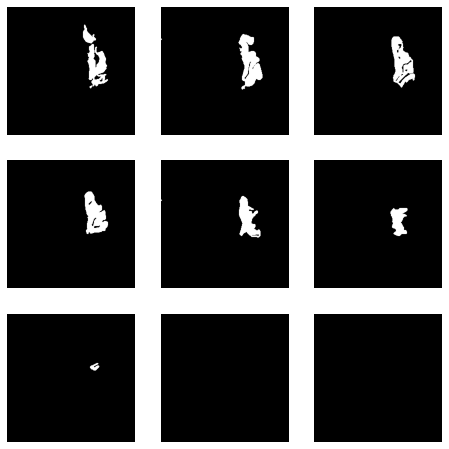

In [43]:
fig,axes = plt.subplots(nrows = 3,ncols = 3, figsize = (8,8),gridspec_kw={'wspace':0.1}) 
for j in range(9): 
    axes[(j)//3,(j)%3].imshow(np.flip(np.rot90(im2[:,:,j+15]),axis = 1),cmap='Greys_r',clim = [0,1])
    axes[(j)//3,(j)%3].axis('off')
    
#plt.savefig('./paper_figures/figure_6/ADC_originimg_9.png')

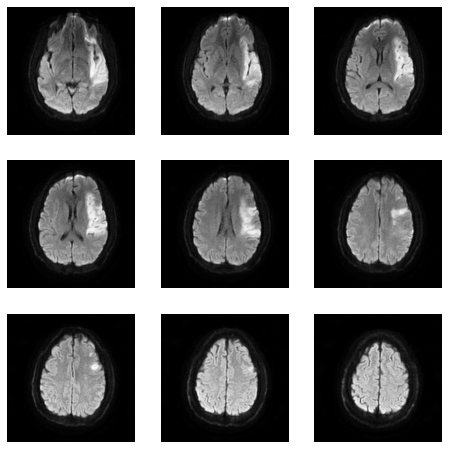

In [45]:
fig,axes = plt.subplots(nrows = 3,ncols = 3, figsize = (8,8),gridspec_kw={'wspace':0.1}) 
for j in range(9): 
    axes[(j)//3,(j)%3].imshow(np.flip(np.rot90(im[:,:,j+15]/np.max(im[:,:,j+15])),axis = 1),cmap='Greys_r',clim = [0,1])
    axes[(j)//3,(j)%3].axis('off')
    
#plt.savefig('./paper_figures/figure_6/ADC_originimg_9.png')

In [185]:
recon_b1000= torch.zeros(2,9,256,256)
results_b1000 = torch.zeros(9,3)

In [186]:
for i in range(9): 
    img1 = np.flip(np.rot90(im[:,:,i+13]/np.max(im[:,:,i+13])),axis = 1).reshape((img1.shape[0],img1.shape[1],1))
    img1 = torch.from_numpy(np.concatenate((img1,np.zeros_like(img1)),2)).float()/np.max(img1)
    img1_k = fft2c_new(img1)
    img1 = fastmri.complex_abs(ifft2c_new(img1_k))
    rcon7,nmse_7,ssim_7,psnr_7 = bayesian_mean_samp_nor(img1_k,ind[mask_r_7.view(-1) == 1],lamb)
    
    recon_b1000[0,i,:,:] = img1
    recon_b1000[1,i,:,:] = rcon7
    results_b1000[i,:] = torch.tensor([nmse_7,ssim_7,psnr_7])
    print(nmse_7,ssim_7,psnr_7)

0.0362671628214484 0.5648793893372097 28.293932698901475
0.030511392694255093 0.6267151862737118 28.794788585797487
0.013349659230315218 0.7923869918096172 32.61999857928576
0.012540203724052517 0.8284669246716354 33.208030877228474
0.012803616209818298 0.8196681885813987 32.80786603809486
0.012874370656853366 0.8473344393897845 33.50353718064109
0.013046069283286381 0.851283383039452 33.792194174667415
0.012947517153168563 0.8083163619692237 31.929934167691236
0.010541559487789728 0.8046717333392284 32.967225809429294


In [187]:
torch.save(recon_b1000,'./paper_figures/figure_6/ADC_img.pt') 
torch.save(results_b1000,'./paper_figures/figure_6/ADC_results.pt')

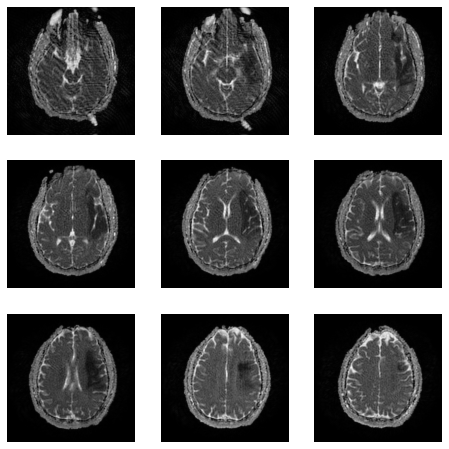

In [188]:
fig,axes = plt.subplots(nrows = 3,ncols = 3, figsize = (8,8),gridspec_kw={'wspace':0.1}) 
for j in range(9): 
    axes[(j)//3,(j)%3].imshow(recon_b1000[1,j,:,:],cmap='Greys_r',clim = [0,1])
    axes[(j)//3,(j)%3].axis('off')
plt.savefig('./paper_figures/figure_5/ADC_reconimg_9.png')

## All Methods ##

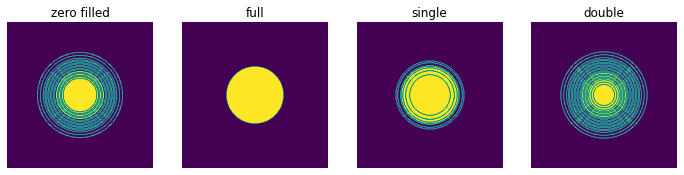

In [8]:
delta_6822_6 = np.linspace(0,49,50,dtype = int)[:35]
delta_6822_12 = np.linspace(0,49,50,dtype = int)[:50]

nor_6822_6 = np.load('./results_gpr_noniter_new/rnor_pattern_6822_opt.npy')[:32]
nor_6822_12 = np.load('./results_gpr_noniter_new/rnor_pattern_6822_opt.npy')[:48]

L1_6822_6 = np.load('./results_gpr_noniter_new/6822_L1_path/rnor_pattern_L1_10_6822_opt_6%.npy')
L1_6822_12 = np.load('./results_gpr_noniter_new/6822_L1_path/rnor_pattern_L1_10_6822_opt_12%.npy')

L1L2_6822_6 = np.load('./results_gpr_noniter_new/rnor_pattern_L1L2_11_6822_opt.npy')[:30]
L1L2_6822_12 = np.load('./results_gpr_noniter_new/rnor_pattern_L1L2_11_6822_opt.npy')[:45]

mask_r_4,mask_r_ratio_4 = mask_of_r_order(imgsz-2*w,nor_6822_12)
mask_r_5,mask_r_ratio_5 = mask_of_r_order(imgsz-2*w,delta_6822_12)
mask_r_6,mask_r_ratio_6 = mask_of_r_order(imgsz-2*w,L1_6822_12)
mask_r_7,mask_r_ratio_7 = mask_of_r_order(imgsz-2*w,L1L2_6822_12)

fig,axes = plt.subplots(nrows = 1,ncols = 4, figsize = (12,3.2))
title = ['zero filled','full','single','double']
axes[0].imshow(mask_larger(256,48,mask_r_4))
axes[0].axis('off')
axes[1].imshow(mask_larger(256,48,mask_r_5))
axes[1].axis('off')
axes[2].imshow(mask_larger(256,48,mask_r_6))
axes[2].axis('off')
axes[3].imshow(mask_larger(256,48,mask_r_7))
axes[3].axis('off')

for i in range(4): 
    axes[i].title.set_text(title[i])

In [190]:
realmean = torch.load('./brain_stats/train_realmean_6822.pt').reshape((160,160))
imagmean = torch.load('./brain_stats/train_imagmean_6822.pt').reshape((160,160))

magmean = torch.load('./brain_stats/train_magmean_6822.pt').reshape((160,160))
##for normalization real/imag import in the lower part!!!!!
realmean = realmean/magmean
imagmean = imagmean/magmean

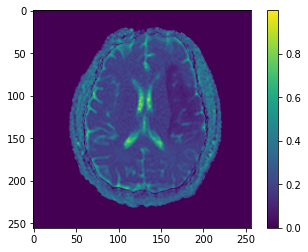

In [191]:
img1 = np.flip(np.rot90(im[:,:,18]/np.max(im[:,:,18])),axis = 1).reshape((img1.shape[0],img1.shape[1],1))
img1 = torch.from_numpy(np.concatenate((img1,np.zeros_like(img1)),2)).float()

img_k0 = fft2c_new(img1)
origin_img = fastmri.complex_abs(ifft2c_new(img_k0))

plt.imshow(origin_img)
plt.colorbar()

In [192]:
realmean = torch.load('./brain_stats/train_realmean_6822.pt').reshape((160,160))
imagmean = torch.load('./brain_stats/train_imagmean_6822.pt').reshape((160,160))

magmean = torch.load('./brain_stats/train_magmean_6822.pt').reshape((160,160))
##for normalization real/imag import in the lower part!!!!!
realmean = realmean/magmean
imagmean = imagmean/magmean

start = time.time()

ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)
lamb = 1e-3

#full recon 
realcov = torch.load('./brain_stats/real_cov_6822_nor.pt') #size((256-w*2)**2,(256-w*2)**2)
imagcov = torch.load('./brain_stats/imag_cov_6822_nor.pt')
realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)

#rcon1,nmse_1,ssim_1,psnr_1 = bayesian_mean_samp_nor(img_k0,ind[mask_r_1.view(-1) == 1],lamb)
rcon5,nmse_5,ssim_5,psnr_5 = bayesian_mean_samp_nor(img_k0,ind[mask_r_5.view(-1) == 1],lamb)

#Delta/Zero Filled 
realcov = torch.eye(160**2,160**2)*realvar
imagcov = torch.eye(160**2,160**2)*imagvar

#rcon0,nmse_0,ssim_0,psnr_0 = bayesian_mean_samp_nor(img_k0,ind[mask_r_0.view(-1) == 1],lamb)
rcon4,nmse_4,ssim_4,psnr_4 = bayesian_mean_samp_nor(img_k0,ind[mask_r_4.view(-1) == 1],lamb)

#Single Envelope 
realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_10.pt') #size((256-w*2)**2,(256-w*2)**2)
imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_10.pt')

#rcon2,nmse_2,ssim_2,psnr_2 = bayesian_mean_samp_nor(img_k0,ind[mask_r_2.view(-1) == 1],lamb)
rcon6,nmse_6,ssim_6,psnr_6 = bayesian_mean_samp_nor(img_k0,ind[mask_r_6.view(-1) == 1],lamb)

#double Envelope 
realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_11_L2_11.pt') #size((256-w*2)**2,(256-w*2)**2)
imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_11_L2_11.pt')

#rcon3,nmse_3,ssim_3,psnr_3 = bayesian_mean_samp_nor(img_k0,ind[mask_r_3.view(-1) == 1],lamb)
rcon7,nmse_7,ssim_7,psnr_7 = bayesian_mean_samp_nor(img_k0,ind[mask_r_7.view(-1) == 1],lamb)

end = time.time()

print('computational time:',end-start,'s')
print('12% nmse')
print(nmse_4,nmse_5,nmse_6,nmse_7)


recon_12percent = torch.zeros(5,256,256)
results_12percent = torch.zeros(4,3)
recon_12percent = torch.cat((origin_img.reshape(1,imgsz,imgsz),rcon4.reshape(1,imgsz,imgsz),rcon5.reshape(1,imgsz,imgsz),\
                            rcon6.reshape(1,imgsz,imgsz),rcon7.reshape(1,imgsz,imgsz)),axis = 0) 

results_12percent[0,:] = torch.tensor([nmse_4,ssim_4,psnr_4])
results_12percent[1,:] = torch.tensor([nmse_5,ssim_5,psnr_5])
results_12percent[2,:] = torch.tensor([nmse_6,ssim_6,psnr_6])
results_12percent[3,:] = torch.tensor([nmse_7,ssim_7,psnr_7])

torch.save(recon_12percent,'./paper_figures/figure_6/ADC_12percent_img.pt')
torch.save(results_12percent,'./paper_figures/figure_6/ADC_12percent_results.pt')


computational time: 132.80385613441467 s
12% nmse
0.029849750446969723 0.04208740102512135 0.020345415149052238 0.012874370656853366


In [170]:
results_12percent

tensor([[5.4188e-03, 7.4886e-01, 3.4502e+01],
        [9.8926e-03, 7.6844e-01, 3.1888e+01],
        [2.3164e-03, 9.2504e-01, 3.8193e+01],
        [8.6068e-04, 9.5960e-01, 4.2492e+01]])

In [193]:
results_12percent

tensor([[2.9850e-02, 5.6127e-01, 2.9851e+01],
        [4.2087e-02, 6.7090e-01, 2.8359e+01],
        [2.0345e-02, 8.1773e-01, 3.1516e+01],
        [1.2874e-02, 8.4733e-01, 3.3504e+01]])

In [5]:
mode = 'b1000'
recon_12percent = torch.load('./paper_figures/figure_6/'+mode+'_12percent_img.pt')
results_12percent = torch.load('./paper_figures/figure_6/'+mode+'_12percent_results.pt')

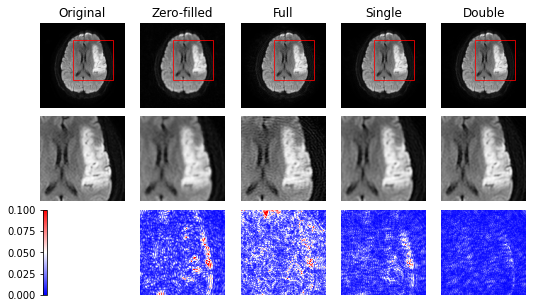

In [222]:
zoomsz = 120
rowlow = 50
collow = 100

import matplotlib.patches as patches
rect = patches.Rectangle((collow, rowlow), zoomsz, zoomsz, linewidth=1, edgecolor='r', facecolor='none')

fig,axes = plt.subplots(nrows = 3,ncols = 5, figsize = (9,5),gridspec_kw={'wspace':0.,'hspace':0.1}) 
for i in range(3): 
    for j in range(5): 
        axes[i,j].axis('off')

#reconstruced, zoomed in, error map; 6% and 12% 
for j in range(5): 
    origin_img = recon_12percent[0,:,:]
#orignal img, zero-filled, full,single envelop, double envelope 
    img = recon_12percent[j,:,:]   
    zoomed_img = img[rowlow:rowlow+zoomsz,collow:collow+zoomsz]
    axes[0,j].imshow(img,cmap='Greys_r',clim = [0,1])
    axes[1,j].imshow(zoomed_img,cmap='Greys_r',clim = [0,1])
    fig2 = axes[2,j].imshow(abs(zoomed_img-origin_img[rowlow:rowlow+zoomsz,collow:collow+zoomsz]) \
                             ,cmap='bwr',clim = [0,0.1])


title = ['Original','Zero-filled','Full','Single','Double']
for i in range(5): 
    axes[0,i].title.set_text(title[i])
    axes[0,i].add_patch(patches.Rectangle((collow, rowlow), zoomsz, zoomsz, \
                                          linewidth=0.8, edgecolor='r', facecolor='none'))
    #axes[3,i].add_patch(patches.Rectangle((collow, rowlow), zoomsz, zoomsz, \
    #                                      linewidth=0.8, edgecolor='r', facecolor='none'))



for i in [2]:
    axes[i,0].set_visible(False)    
   
fig.colorbar(fig2,ax = axes[2,0],location='left')


plt.savefig('./paper_figures/figure_6/'+mode+'_6822_reconbrainimg.png')

In [100]:
mask_r_7,mask_r_ratio_7 = mask_of_r_order(imgsz-2*w,L1L2_6822_12[:19])
print(mask_r_ratio_7 )

tensor([6.1035e-05, 1.8311e-04, 4.8828e-04, 1.2207e-03, 1.7090e-03, 2.8687e-03,
        3.9062e-03, 5.5542e-03, 5.8594e-03, 7.8735e-03, 8.5449e-03, 1.0010e-02,
        1.2329e-02, 1.4465e-02, 1.7456e-02, 1.8433e-02, 2.0569e-02, 2.3743e-02,
        2.6489e-02])


In [103]:
mask_r_9,mask_r_ratio_9 = mask_of_r_order(imgsz-2*w,delta_6822_12[:23])
print(mask_r_ratio_9 )

tensor([6.1035e-05, 1.8311e-04, 4.8828e-04, 7.9346e-04, 1.2207e-03, 1.7090e-03,
        2.3804e-03, 3.1738e-03, 3.9062e-03, 4.8218e-03, 5.8594e-03, 6.8359e-03,
        8.2397e-03, 9.3994e-03, 1.0925e-02, 1.2390e-02, 1.3916e-02, 1.5564e-02,
        1.7151e-02, 1.9287e-02, 2.1301e-02, 2.3315e-02, 2.5391e-02])


In [104]:
L1L2_6822_12 = np.load('./results_gpr_noniter_new/rnor_pattern_L1L2_11_6822_opt.npy')
mask_r_7,mask_r_ratio_7 = mask_of_r_order(imgsz-2*w,L1L2_6822_12[:17])
mask_r_8,mask_r_ratio_8 = mask_of_r_order(imgsz-2*w,L1L2_6822_12[:45])

delta_6822_12 = np.linspace(0,49,50,dtype = int)
mask_r_9,mask_r_ratio_9 = mask_of_r_order(imgsz-2*w,delta_6822_12[:21])
mask_r_10,mask_r_ratio_10 = mask_of_r_order(imgsz-2*w,delta_6822_12[:50])
ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)
lamb = 1e-3



img1 = np.flip(np.rot90(im[:,:,19]),axis = 1).reshape((im.shape[0],im.shape[1],1))/np.max(im[:,:,19])
img1 = torch.from_numpy(np.concatenate((img1,np.zeros_like(img1)),2)).float()
img1_k = fft2c_new(img1)
img1 = fastmri.complex_abs(ifft2c_new(img1_k))



ind = np.linspace(0,(imgsz-2*w)**2-1,(imgsz-2*w)**2,dtype = int)
lamb = 1e-3

#doubvle envelope
realcov = torch.load('./results_gpr_hyper_new/covmat_6822/realcov_L1_11_L2_11.pt') #size((256-w*2)**2,(256-w*2)**2)
imagcov = torch.load('./results_gpr_hyper_new/covmat_6822/imagcov_L1_11_L2_11.pt')

realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)

rcon7,nmse_7,ssim_7,psnr_7 = bayesian_mean_samp_nor(img1_k,ind[mask_r_7.view(-1) == 1],lamb)
rcon8,nmse_8,ssim_8,psnr_8 = bayesian_mean_samp_nor(img1_k,ind[mask_r_8.view(-1) == 1],lamb)

# zero-filled
realcov = torch.load('./brain_stats/real_cov_6822_nor.pt') #size((256-w*2)**2,(256-w*2)**2)
imagcov = torch.load('./brain_stats/imag_cov_6822_nor.pt')
realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)

realvar= torch.diagonal(realcov)
imagvar= torch.diagonal(imagcov)

realcov = torch.eye(160**2,160**2)*realvar
imagcov = torch.eye(160**2,160**2)*imagvar



rcon9,nmse_9,ssim_9,psnr_9 = bayesian_mean_samp_nor(img1_k,ind[mask_r_9.view(-1) == 1],lamb)
rcon10,nmse_10,ssim_10,psnr_10 = bayesian_mean_samp_nor(img1_k,ind[mask_r_10.view(-1) == 1],lamb)

print(nmse_7,ssim_7,psnr_7)
print(nmse_8,ssim_8,psnr_8)
print(nmse_9,ssim_9,psnr_9)
print(nmse_10,ssim_10,psnr_10)

0.011943721997567552 0.8115952371646414 31.65022263770031
0.0007383702008019787 0.9664274243256717 43.738878198045185
0.0192859620444671 0.7861401458104775 29.569206342632025
0.002415788813563828 0.9597248983878638 38.5910308369461


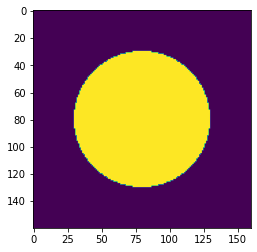

In [56]:
plt.imshow(mask_r_10)

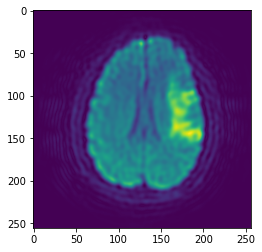

In [92]:
plt.imshow(rcon7)

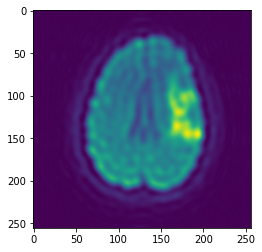

In [91]:
plt.imshow(rcon9)

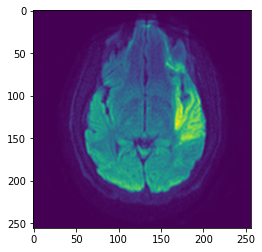

In [58]:
plt.imshow(img1)

In [105]:
stroke = torch.from_numpy(np.flip(np.rot90(im2[:,:,19]),axis = 1).astype(float))
recon_12percent = torch.zeros(6,256,256)
results_12percent = torch.zeros(4,3)
recon_12percent = torch.cat((stroke.reshape(1,imgsz,imgsz),img1.reshape(1,imgsz,imgsz), \
                             rcon9.reshape(1,imgsz,imgsz),rcon7.reshape(1,imgsz,imgsz),\
                            rcon10.reshape(1,imgsz,imgsz),rcon8.reshape(1,imgsz,imgsz)),axis = 0) 

results_12percent[0,:] = torch.tensor([nmse_7,ssim_7,psnr_7])
results_12percent[1,:] = torch.tensor([nmse_8,ssim_8,psnr_8])
results_12percent[2,:] = torch.tensor([nmse_9,ssim_9,psnr_9])
results_12percent[3,:] = torch.tensor([nmse_10,ssim_10,psnr_10])

#torch.save(recon_12percent,'./paper_figures/figure_6/b1000_small_stroke_6_12_img.pt')
#torch.save(results_12percent,'./paper_figures/figure_6/b1000_small_stroke_6_12_results.pt')

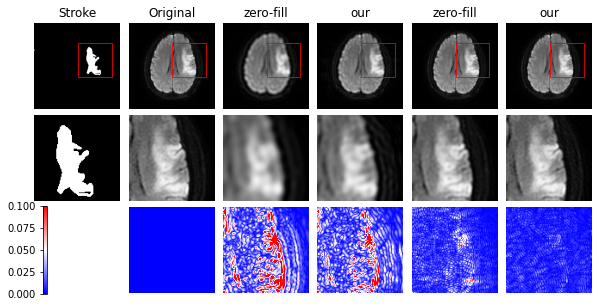

In [107]:
zoomsz = 100
rowlow = 60
collow = 130

import matplotlib.patches as patches
rect = patches.Rectangle((collow, rowlow), zoomsz, zoomsz, linewidth=1, edgecolor='r', facecolor='none')

fig,axes = plt.subplots(nrows = 3,ncols = 6, figsize = (10,5),gridspec_kw={'wspace':0.1,'hspace':0.05}) 
for i in range(3): 
    for j in range(6): 
        axes[i,j].axis('off')

#reconstruced, zoomed in, error map; 6% and 12% 
for j in range(6): 
    origin_img = recon_12percent[1,:,:]
#orignal img, zero-filled, full,single envelop, double envelope 
    img = recon_12percent[j,:,:]   
    zoomed_img = img[rowlow:rowlow+zoomsz,collow:collow+zoomsz]
    axes[0,j].imshow(img,cmap='Greys_r',clim = [0,1])
    axes[1,j].imshow(zoomed_img,cmap='Greys_r',clim = [0,1])
    fig2 = axes[2,j].imshow(abs(zoomed_img-origin_img[rowlow:rowlow+zoomsz,collow:collow+zoomsz]) \
                             ,cmap='bwr',clim = [0,0.1])


title = ['Stroke','Original','zero-fill','our','zero-fill','our']
for i in range(6): 
    axes[0,i].title.set_text(title[i])
    axes[0,i].add_patch(patches.Rectangle((collow, rowlow), zoomsz, zoomsz, \
                                          linewidth=0.8, edgecolor='r', facecolor='none'))
    #axes[3,i].add_patch(patches.Rectangle((collow, rowlow), zoomsz, zoomsz, \
    #                                      linewidth=0.8, edgecolor='r', facecolor='none'))



for i in [2]:
    axes[i,0].set_visible(False)    
   
fig.colorbar(fig2,ax = axes[2,0],location='left')


plt.savefig('./paper_figures/figure_6/small_stroke_brainrcon.pdf')